In [18]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

In [19]:
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
response = requests.get(url)
soup = BeautifulSoup(response.content, 'html.parser')


table = soup.find('table', {'id': 'constituents'})
rows = table.find_all('tr')



I delete 4 tickers to clean the constituent data

In [20]:
# Extract the data
sp500_tickers = []
sectors = []
excluded_tickers = {'BF.B', 'SOLV', 'GEV', 'BRK.B'}
for row in rows[1:]:
    cols = row.find_all('td')
    ticker = cols[0].text.strip()
    sector = cols[3].text.strip()
    if ticker not in excluded_tickers:
        sp500_tickers.append(ticker)
        sectors.append(sector)


sp500_df = pd.DataFrame({'Ticker': sp500_tickers, 'Sector': sectors})


data = yf.download(sp500_tickers, start='2018-01-01', end='2023-12-31')['Adj Close']

# Calculate the annual volatility 
daily_returns = data.pct_change().dropna()
annual_volatility = daily_returns.std() * np.sqrt(252)

# volatility
sp500_df['Volatility'] = sp500_df['Ticker'].apply(lambda x: annual_volatility.get(x, np.nan))

# Select the 5 least volatile stocks from each sector
least_volatile_stocks = sp500_df.groupby('Sector').apply(lambda x: x.nsmallest(5, 'Volatility')).reset_index(drop=True)

# Fetch the historical data for the selected stocks
selected_tickers = least_volatile_stocks['Ticker'].tolist()
selected_data = yf.download(selected_tickers, start='2018-01-01', end='2023-12-31')['Adj Close']

# Calculate daily returns
selected_daily_returns = selected_data.pct_change().dropna()

# Calculate mean returns and covariance matrix
mean_returns = selected_daily_returns.mean()
cov_matrix = selected_daily_returns.cov()


[*********************100%%**********************]  499 of 499 completed
[*********************100%%**********************]  384 of 384 completed


Building the index and calculating performance

In [21]:
# Equal weighting for simplicity
num_stocks = len(selected_tickers)
weights = np.array([1.0 / num_stocks] * num_stocks)

# Portfolio performance
portfolio_return = np.dot(weights, mean_returns) * 252
portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
portfolio_sharpe_ratio = (portfolio_return - 0.01) / portfolio_volatility

print(f'Custom Index Performance:\nReturn: {portfolio_return:.2f}\nVolatility: {portfolio_volatility:.2f}\nSharpe Ratio: {portfolio_sharpe_ratio:.2f}')


Custom Index Performance:
Return: 0.55
Volatility: 0.14
Sharpe Ratio: 3.83


Comparing with SP500 performance

In [22]:
# Fetch the S&P 500 index data
sp500_index = yf.download('^GSPC', start='2018-01-01', end='2023-12-31')['Adj Close']

# Calculate S&P 500 performance metrics
sp500_daily_returns = sp500_index.pct_change().dropna()
sp500_annual_return = sp500_daily_returns.mean() * 252
sp500_volatility = sp500_daily_returns.std() * np.sqrt(252)
sp500_sharpe_ratio = (sp500_annual_return - 0.01) / sp500_volatility

print(f'S&P 500 Performance:\nReturn: {sp500_annual_return:.2f}\nVolatility: {sp500_volatility:.2f}\nSharpe Ratio: {sp500_sharpe_ratio:.2f}')




[*********************100%%**********************]  1 of 1 completed
S&P 500 Performance:
Return: 0.12
Volatility: 0.21
Sharpe Ratio: 0.52


The following graph allows us to visualise the superior performance of the custom SP500 index

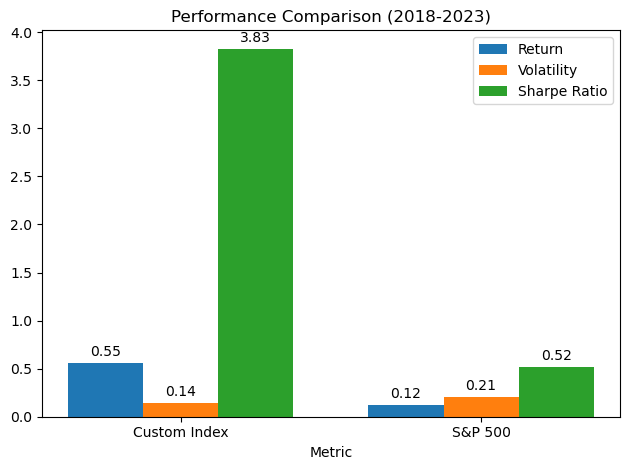

In [23]:
# Plot comparison
labels = ['Custom Index', 'S&P 500']
returns = [portfolio_return, sp500_annual_return]
volatilities = [portfolio_volatility, sp500_volatility]
sharpe_ratios = [portfolio_sharpe_ratio, sp500_sharpe_ratio]

x = np.arange(len(labels))  
width = 0.25  

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, returns, width, label='Return')
rects2 = ax.bar(x, volatilities, width, label='Volatility')
rects3 = ax.bar(x + width, sharpe_ratios, width, label='Sharpe Ratio')


ax.set_xlabel('Metric')
ax.set_title('Performance Comparison (2018-2023)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()

plt.show()